# SE1

Jordan's SE1 is a regression problem with $n = 200$ samples, $p = 2$ features and a linear signal $f(X) = X_1$. The response $Y$ is constructed as 

$$Y = f(X) + \varepsilon U,$$

where $U \sim \mathsf{N}(0,1)$ is an independent noise and $\varepsilon = 0.1$ is the noise level. The covariates $X_i$, $i \in [p]$, are drawn from a centered multivariate normal with a covariance matrix having Toeplitz structure, that is

$$\mathrm{Cov}(X_i, X_j) = \rho^{|i-j|},$$
where $\rho \in (0,1)$.

**Generator for reproducibility**

In [1]:
import torch

In [2]:
torch.manual_seed(16371051889608979414)

**Visualization**

In [3]:
from pyselect.data import jordan_se1

In [4]:
X_se1, y_se1 = jordan_se1(rho=0.2)

In [5]:
import matplotlib.pyplot as plt
plt.style.use("../../../figures/pyselect.mplstyle")

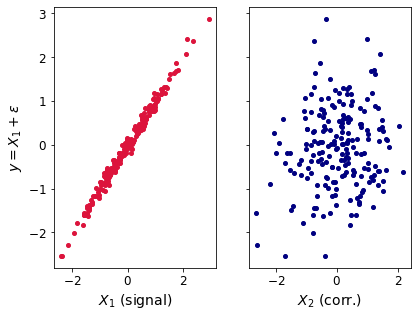

In [6]:
fig,(ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.plot(X_se1[:, 0], y_se1, 'o', markersize=4, color='crimson')
ax1.set_xlabel(r"$X_1$ (signal)")
ax1.set_ylabel(r"$y = X_1 + \epsilon$")
ax2.plot(X_se1[:, 1], y_se1, 'o', 
         markersize=4, color='navy')
ax2.set_xlabel("$X_2$ (corr.)")
plt.show()

## Setup

In [7]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss
from ignite.handlers import LRScheduler, BasicTimeProfiler, EarlyStopping
from pyselect.networks import RandomFourierFeaturesNet

### Device

In [8]:
device = torch.device("cpu")

### Datasets

Generate data with fixed random seed.

In [9]:
X_se1, y_se1 = jordan_se1(n_samples=400, rho=0.5)

Move to device

In [10]:
X_se1 = X_se1.to(device)
y_se1 = y_se1.to(device)

Data-splitting and generate datasets

In [11]:
train_size = 200
val_size = 100
test_size = 100

In [12]:
jordan_train_val_test = torch.utils.data.TensorDataset(X_se1, y_se1)

In [13]:
train, val, test = torch.utils.data.random_split(jordan_train_val_test, [train_size, val_size, test_size])

### Dataloaders

In [14]:
batch_size = 32

In [15]:
train_loader = DataLoader(train, batch_size=batch_size)
val_loader = DataLoader(val, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

### Model

In [16]:
in_features = 2
out_features = 50

In [17]:
model = RandomFourierFeaturesNet(in_features, out_features)
model.to(device)

RandomFourierFeaturesNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=2)
    (1): RandomFourierFeaturesLayer(in_features=2, out_features=50)
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [18]:
model.rff_net[0].reset_parameters(1/in_features)

### Optimizer

In [19]:
lr = 1e-1
reg_param = 1e-4

In [20]:
optimizer = optim.SGD([{'params': model.rff_net[0].parameters()}, {'params':model.rff_net[2].weight, 'weight_decay': 2 * reg_param}, {'params': model.rff_net[2].bias}], lr=lr)

### Loss

In [21]:
from torch.nn import MSELoss

In [22]:
loss_fn = MSELoss()

### Trainer

In [23]:
n_epochs = 200

In [24]:
trainer = create_supervised_trainer(model, optimizer, loss_fn, device)

### Evaluators

In [25]:
val_metric = {"loss": Loss(loss_fn)}    
train_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)                                                
val_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)

### Scheduler

In [26]:
n_steps = 3
gamma = 0.95

In [27]:
step_size = len(train_loader)*n_epochs//n_steps
torch_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
scheduler = LRScheduler(torch_scheduler)

In [28]:
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)

### Logger

In [29]:
log_every = 10

In [30]:
def log_training_results(engine):
    train_evaluator.run(train_loader)
    loss = train_evaluator.state.metrics['loss']
    print(f"Training - Epoch: {engine.state.epoch} Loss: {loss:.5f}")
    
def log_validation_results(engine):
    val_evaluator.run(val_loader)
    loss = val_evaluator.state.metrics['loss']
    print(f"Validation - Epoch: {engine.state.epoch} Loss: {loss:.5f}")    

def log_lr():
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.4f}")

In [31]:
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=log_every), log_training_results)
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=log_every), log_validation_results)
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=log_every), log_lr)

### Early Stopping

In [32]:
def score_function(engine):
    val_loss = engine.state.metrics['loss']
    return -val_loss

In [33]:
patience = 5

In [34]:
early_stopping = EarlyStopping(patience=patience, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, early_stopping)

### Time Profiler

In [35]:
time_profiler = BasicTimeProfiler()
time_profiler.attach(trainer)

## Train

In [36]:
trainer.run(train_loader, max_epochs=n_epochs)

Training - Epoch: 10 Loss: 0.07558
Validation - Epoch: 10 Loss: 0.07061
Learning rate: 0.1000
Training - Epoch: 20 Loss: 0.03705
Validation - Epoch: 20 Loss: 0.03661
Learning rate: 0.1000
Training - Epoch: 30 Loss: 0.02762
Validation - Epoch: 30 Loss: 0.02832
Learning rate: 0.1000
Training - Epoch: 40 Loss: 0.02339
Validation - Epoch: 40 Loss: 0.02460
Learning rate: 0.1000
Training - Epoch: 50 Loss: 0.02095
Validation - Epoch: 50 Loss: 0.02246
Learning rate: 0.1000
Training - Epoch: 60 Loss: 0.01933
Validation - Epoch: 60 Loss: 0.02105
Learning rate: 0.1000
Training - Epoch: 70 Loss: 0.01819
Validation - Epoch: 70 Loss: 0.02007
Learning rate: 0.0950
Training - Epoch: 80 Loss: 0.01735
Validation - Epoch: 80 Loss: 0.01933
Learning rate: 0.0950
Training - Epoch: 90 Loss: 0.01668
Validation - Epoch: 90 Loss: 0.01875
Learning rate: 0.0950
Training - Epoch: 100 Loss: 0.01613
Validation - Epoch: 100 Loss: 0.01827
Learning rate: 0.0950
Training - Epoch: 110 Loss: 0.01567
Validation - Epoch: 11

State:
	iteration: 1400
	epoch: 200
	epoch_length: 7
	max_epochs: 200
	output: 0.004166099242866039
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

## Visualization

### Bands

In [37]:
import numpy as np

In [38]:
bands = model.rff_net[0].bandwidths.detach().to('cpu').numpy()
indexes = np.arange(1, 3)

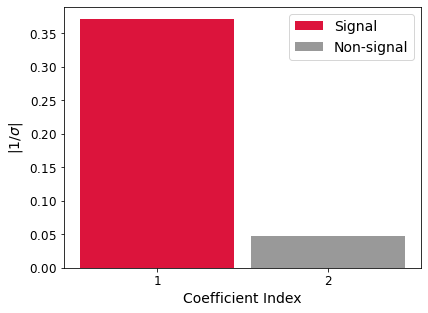

In [39]:
plt.bar(indexes[0], np.abs(bands)[0], width=0.9, color='crimson', label='Signal')
plt.bar(indexes[1], np.abs(bands)[1], width=0.9, color='black', alpha=0.4, label='Non-signal')
ax = plt.gca()
ax.ticklabel_format(axis="x", style="plain")
ax.set_xlabel("Coefficient Index")
ax.set_ylabel(r"$| 1/\sigma |$")
ax.set_xticks([1, 2])
plt.legend()
plt.show()

### Predictions on test

In [40]:
model.to('cpu')

RandomFourierFeaturesNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=2)
    (1): RandomFourierFeaturesLayer(in_features=2, out_features=50)
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [41]:
X_test, y_test = test.dataset[test.indices]

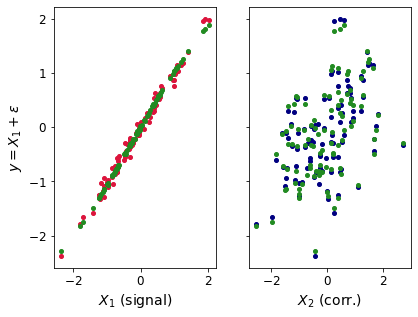

In [42]:
fig,(ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.plot(X_test[:, 0], y_test, 'o', markersize=4, color='crimson')
ax1.plot(X_test[:, 0], model(X_test).detach().squeeze().numpy(), 'o', markersize=4, color='forestgreen')
ax1.set_xlabel(r"$X_1$ (signal)")
ax1.set_ylabel(r"$y = X_1 + \epsilon$")
ax2.plot(X_test[:, 1], y_test, 'o', markersize=4, color='navy')
ax2.set_xlabel("$X_2$ (corr.)")
ax2.plot(X_test[:, 1], model(X_test).detach().squeeze().numpy(), 'o', markersize=4, color='forestgreen')
plt.show()

In [43]:
sorted_y_test = y_test.squeeze().sort(dim=0)[0].numpy()

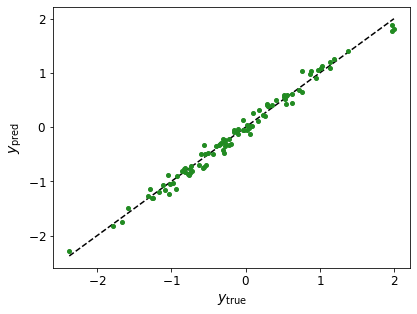

In [44]:
plt.plot(y_test, model(X_test).detach().squeeze().numpy(), 'o', markersize=4, color='forestgreen')
plt.plot(sorted_y_test, sorted_y_test, color='k', linestyle='dashed', zorder=-10)
plt.xlabel(r"$y_{\mathrm{true}}$")
plt.ylabel(r"$y_{\mathrm{pred}}$")
plt.show()

### Time profiling

In [45]:
results = time_profiler.get_results()

In [46]:
time_profiler.print_results(results);


 ----------------------------------------------------
| Time profiling stats (in seconds):                 |
 ----------------------------------------------------
total  |  min/index  |  max/index  |  mean  |  std

Processing function:
0.52595 | 0.00030/1266 | 0.02592/0 | 0.00038 | 0.00069

Dataflow:
0.31108 | 0.00010/1384 | 0.00059/454 | 0.00022 | 0.00007

Event handlers:
0.12195

- Events.STARTED: []
0.00001

- Events.EPOCH_STARTED: []
0.00031 | 0.00000/162 | 0.00000/9 | 0.00000 | 0.00000

- Events.ITERATION_STARTED: ['LRScheduler']
0.01738 | 0.00001/1271 | 0.00005/800 | 0.00001 | 0.00000

- Events.ITERATION_COMPLETED: []
0.00324 | 0.00000/1397 | 0.00001/1363 | 0.00000 | 0.00000

- Events.EPOCH_COMPLETED: ['log_training_results', 'log_validation_results', 'log_lr']
0.09593 | 0.00001/198 | 0.00567/9 | 0.00048 | 0.00141

- Events.COMPLETED: []
0.00000

